## Import the packages / functions

In [152]:
import matplotlib as mpl
# mpl.use("pgf")
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import time

import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from tqdm.notebook import trange
from sklearn import decomposition
from sklearn.linear_model import LinearRegression
from functools import partial

import torch
import vjf
from vjf import online

from tqdm.notebook import trange

## Import the dataset (pick one!) 

#### run the cell below for the example lorenz attractor dataset 

In [3]:
# The data loading below is the lorenz attractor with (1 trajectory, 3dim, 500 to 20500 time points, with noise sd=0.05)
data = np.load('lorenz_1trajectories_3dim_500to20500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the example vanderpol dataset 

In [39]:
# The data loading below is the lorenz attractor with (1 trajectory, 3dim, 500 to 2500 time points, with noise sd=0.05)
data = np.load('vdp_1trajectories_200dim_500to20500_noise0.05.npz')

xs = data['x']  # state
ys = data['y']  # observation
us = data['u']  # control input
xdim = xs.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the reduced jPCA dataset

In [123]:
data = np.load('jpca_reduced.npy')

xs = None  # state
ys = data  # observation
ys = ys[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))  # control input
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the reduced Neuropixel dataset

In [134]:
data = np.load('neuropixel_reduced.npz')['ssSVD10'] # you can change this to 'ssSVD20'

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the reduced widefield calcium imaging dataset

In [144]:
data = np.load('widefield_reduced.npy')

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### run the cell below for the reduced mouse video dataset

In [153]:
data = np.load('reduced_mouse.npy')

xs = None
ys = data.T[None, ...]
us = np.zeros((ys.shape[0], ys.shape[1], 1))
xdim = ys.shape[-1]
ydim = ys.shape[-1]
udim = us.shape[-1]

#### Check your data dimension

In [154]:
ys.shape

(1, 89900, 2)

## Derivation 
ref: http://www.cs.columbia.edu/~liulp/pdf/linear_normal_dist.pdf

$ p(y_t \vert y_{\leq{t-1}}) = \iint p(y_t \vert x_t) p(x_t \vert x_{t-1}) p(x_{t-1} \vert y_{\leq{t-1}}) dx_{t-1} dx_t $


* $ p(x_{t-1} \vert y_{\leq{t-1}}) \longrightarrow \text{filtering}\longrightarrow N(\mu_f, \Sigma_f) \in \mathbb{R}^dx $ 


* $ p(x_t \vert x_{t-1}) \longrightarrow \text{transition} \longrightarrow N(W_s x_{t-1}, \Sigma_s) \in \mathbb{R}^dx $


* $ p(x_t \vert y_{\leq{t-1}}) = p(x_t \vert x_{t-1}) p(x_{t-1} \vert y_{\leq{t-1}}) \sim N(W_s \mu_f, W_s \Sigma_f W^T_s + \Sigma_s)$


* $ p(y_t \vert x_t) \longrightarrow \text{decoder} \longrightarrow N(W_d x_t + b_d, \Sigma_d)$


* $ p(y_t \vert y_{\leq{t-1}}) = N(W_d W_s \mu_f + b_d, W_d (W_s \Sigma_f W_s^T + \Sigma_s) W_d^T + \Sigma_d)$

## Fit the model & save the log probability 
(Important to Note that the dynamics is now 'RBF')

In [155]:
device = 'cuda:0'

In [156]:
likelihood = 'gaussian'  # Gaussian observation
dynamics = 'rbf'  # RBF network dynamic model
recognizer = "mlp"  # MLP recognitiom model
rdim = 50  # number of RBFs
hdim = 100  # number of MLP hidden units

mdl = online.VJF(
    config=dict(
        resume=False,
        xdim=xdim,
        ydim=ydim,
        udim=udim,
        Ydim=udim,
        Udim=udim,
        rdim=rdim,
        hdim=hdim,
        lr=1e-3,
        clip_gradients=5.0,
        debug=True,
        likelihood=likelihood,  # 
        system=dynamics,
        recognizer=recognizer,
        C=(None, True),  # loading matrix: (initial, estimate)
        b=(None, True),  # bias: (initial, estimate)
        A=(None, False),  # transition matrix if LDS
        B=(np.zeros((xdim, udim)), False),  # interaction matrix
        Q=(1.0, True),  # state noise
        R=(1.0, True),  # observation noise
    )
).to(device)

{'A': (None, False),
 'B': (array([[0.],
       [0.]]), False),
 'C': (None, True),
 'Q': (1.0, True),
 'R': (1.0, True),
 'Udim': 1,
 'Ydim': 1,
 'activation': 'tanh',
 'b': (None, True),
 'batch_norm': False,
 'clip_gradients': 5.0,
 'debug': True,
 'hdim': 100,
 'likelihood': 'gaussian',
 'lr': 0.001,
 'optimizer': 'adam',
 'path': '/home/nayoungjun/workspace/vjf/notebook',
 'random_seed': None,
 'rdim': 50,
 'recognizer': 'mlp',
 'resume': False,
 'system': 'rbf',
 'udim': 1,
 'xdim': 2,
 'ydim': 2}
Gaussian likelihood


In [157]:
yy = torch.from_numpy(ys).float().to(device)
uu = torch.from_numpy(us).float().to(device)

EXAMPLE = 0  # the example for calculating the likelihood

# yy = torch.from_numpy(ys[EXAMPLE]).float()
# uu = torch.from_numpy(us[EXAMPLE]).float()

q = None

logprobs = []
distances = []

Note that we are using only the first trajectory to compute the log probability.

We can combine all of the trajectories to make the training better & noise lower.

In [158]:
def diagonal_normal_logpdf(mean, variance, sample):
    mean = mean.flatten()
    variance = variance.flatten()
    sample = sample.flatten()
    
    assert len(mean) == len(variance) == len(sample), f"inconsistent shape: {mean.shape}, {variance.shape}, {sample.shape}"
    
    logprobs = []
    for i in range(len(sample)):
        x = sample[i]
        m = mean[i]
        v = variance[i]
        logprobs.append(-0.5 * ((x - m) ** 2 / v + np.log(2 * np.pi * v)))
    return sum(logprobs)


In [159]:
logprobs = []
distances = []
trial = 0

for _ in trange(1):
    batch_size = 1
    filtering_mu = torch.zeros(batch_size, xdim, device=device)
    filtering_logvar = torch.zeros(batch_size, xdim, device=device)
    q = filtering_mu, filtering_logvar
    logprob_per_trial = []
    
    for time in trange(yy.shape[1]):

        y = yy[trial, time].unsqueeze(0)
        u = uu[trial, time].unsqueeze(0)

        if trial%10 == 0:
        
            filtering_mu, filtering_logvar = q

            mu_f = filtering_mu[0].detach().cpu().numpy().T
            var_f = filtering_logvar[EXAMPLE].detach().exp().cpu().numpy().T
            Sigma_f = np.eye(xdim) * var_f


            N = 100
            x = multivariate_normal(mu_f.flatten(), Sigma_f).rvs(size=N).astype(np.float32)
            x = torch.from_numpy(x).to(device)
            x += mdl.system.velocity(x) + mdl.system.noise.var ** 0.5 * torch.randn_like(x)
            y_tilde = mdl.decoder(x).detach().cpu().numpy()

            y_var = mdl.likelihood.logvar.detach().exp().cpu().numpy().T
            logprob = logsumexp([diagonal_normal_logpdf(y_t, y_var, y.cpu().numpy()) for y_t in y_tilde]) - np.log(N)

            logprob_per_trial.append(logprob)
            distances.append(np.linalg.norm(y_tilde - y[EXAMPLE].cpu().numpy(), axis=-1).mean())
        
        q, loss = mdl.feed((y, u), q)

    if len(logprob_per_trial) > 0:
        logprobs.append(logprob_per_trial)
        

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/89900 [00:00<?, ?it/s]

In [161]:
np.save('logprob_vjf_mouse.npy', np.array(logprobs[0]))

In [21]:
vjf = np.load('logprob_jpca_updated.npy')

In [80]:
bwrap = np.load('jpca_bubblewrap_results.npy')

In [22]:
vjf.shape

(2268,)

## Plotting the log probability 

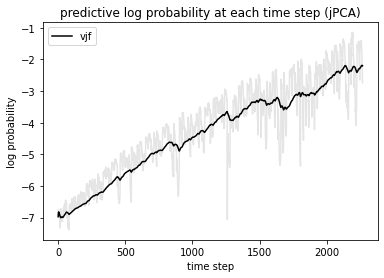

In [24]:
import pandas as pd
def ewma(data, com):
    return np.array(pd.DataFrame(data=dict(data=data)).ewm(com).mean()['data'])

plt.plot(vjf, color='grey', alpha=0.2)
#plt.plot(bwrap, color='lightblue', alpha=0.2)

ax = plt.gca()
ax.plot(ewma(vjf, 100), color='black', label='vjf')
#ax.plot(ewma(bwrap, 100), color='blue', label='bubblewrap')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel('time step')
ax.set_ylabel('log probability')
ax.set_title('predictive log probability at each time step (jPCA)')
ax.legend()
# x.set_ylim([-50,50])
# ax.set_ylim([-5,0])
# ax.set_ylim([-15, 5])

In [82]:
# Plotting for 10 epochs

(-5.0, 5.0)

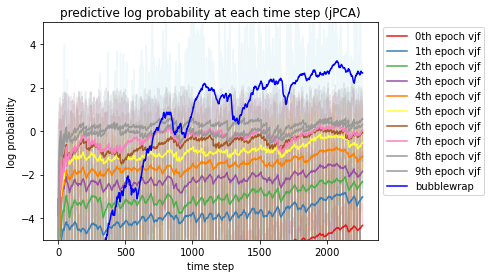

In [92]:
cmap = plt.cm.get_cmap('Set1')
min_ep = 0
max_ep = 9


def ep_color(ep):
    return cmap( (ep - min_ep) / (max_ep - min_ep) )


import pandas as pd
def ewma(data, com):
    return np.array(pd.DataFrame(data=dict(data=data)).ewm(com).mean()['data'])


for ep in range(vjf.shape[0]):
    plt.plot(vjf[ep], color=ep_color(ep), alpha=0.2)
    
plt.plot(bwrap, color='lightblue', alpha=0.2)

ax = plt.gca()

for ep in range(vjf.shape[0]):
    ax.plot(ewma(vjf[ep], 100), color=ep_color(ep), label=f"{ep}th epoch vjf")
    
ax.plot(ewma(bwrap, 100), color='blue', label='bubblewrap')
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel('time step')
ax.set_ylabel('log probability')
ax.set_title('predictive log probability at each time step (jPCA)')
ax.legend(bbox_to_anchor=(1,1))
# x.set_ylim([-50,50])
# ax.set_ylim([-5,0])
ax.set_ylim([-5, 5])

## compute mean and std of the last half of the time points

In [445]:
np.array(logprobs[0][1134:]).mean()

-1472.1861296865127


In [446]:
np.array(logprobs[0][1134:]).std()

10144.209815903732
